# Investigating competition effects between 8 theoretical pre-miRNAs

## Set up workspace

In [1]:
import model_utils as mu
import params
from scipy.integrate import solve_ivp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from tqdm import tqdm

In [2]:
destdir_csvs = './outputs/8sp-comp/csvs/'
destdir_figs = './outputs/8sp-comp/plots/'

## Generate model

In [3]:
#make 2 miRNA model
ODE_inits = [0]*8*4 + [0]
ODE_ka = [0] * 8
ODE_kb = ODE_ka
ODE_kc = ODE_ka
ODE_kd = ODE_ka

In [4]:
ode = mu.makeODEs(ODE_inits, ODE_ka, ODE_kb, ODE_kc, ODE_kd)

In [5]:
model = mu.makeModel(ode)

## Set up conditions for models

In [6]:
high = 10
low = 1
k = 2

In [7]:
inits1 = [params.init_pMiR1, params.init_pMiR1_dcr, params.init_pMiR1_dcr_star, params.init_MiR1] * 8

In [8]:
ka = [params.ka1 * high, params.ka1 * low] + [params.ka1] * 2 +\
     [params.ka1 * high * k, params.ka1 * low] + [params.ka1 * k] * 2

kb = [params.ka1 * params.Kd_wt, params.ka1 * params.Kd_wt * high]  + \
    [params.ka1 * params.Kd_wt] * 2 + \
    [params.ka1 * params.Kd_wt, params.ka1 * params.Kd_wt * high * k] +\
    [params.ka1 * params.Kd_wt] * 2

kc = [params.kc1] * 2 + [params.kc1 * high, params.kc1] + \
     [params.kc1] * 2 + [params.kc1 * high * k, params.kc1]

kd = [params.kd1] * 3 + [params.kd1 * high] + [params.kd1] * 3 + [params.kd1 * high * k]

In [9]:
dvars = np.linspace(0, 7.25, 15)
dvars[0] = 0.01
dvars = np.append(dvars, np.linspace(10, 15, 4))
variations = [str(int(i * 100)) for i in list(dvars)]

## Run model, save outputs

In [10]:
exec(model)

In [11]:
names = []
for i in tqdm(range(len(dvars))):
    init = inits1 + [dvars[i]]
    
    res = solve_ivp(runModel, (0, int(params.minutes)), init, \
                    args = (ka, kb, kc, kd), method = 'LSODA')
    
    mirna_length = int((len(res.y)-1)/4)
    index = []
    
    for j in range(mirna_length):
        index = index + ['pMiR' + str(j), 'pMiR_dicer' + str(j), \
                         'pMiR_dicer_star' + str(j), 'miR' + str(j)]
    
    index = index + ['dicer']
    
    df = pd.DataFrame(res.y, index = index)
    df = df.transpose()
    df.insert(loc = 0, column = 'time_min', value = res.t)
    
    name = 'model_' + variations[i]
    names.append(name)
    
    df.to_csv(destdir_csvs + name + '.csv', index = False)

100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 52.13it/s]


## Plot models

### Load data

In [12]:
for name in names:
    exec(name  + ' = pd.read_csv("' + destdir_csvs + name + '.csv", header = [0])')

In [13]:
#mirna species names
mirnas = ['high $k_a$', 'high $k_b$', 'high $k_c$', 'high $k_d$']
mirnas += [str(int(k)) + 'x ' + i for i in mirnas]

In [14]:
names[-1]

'model_1500'

In [15]:
#prep endpoints for plotting
ends = {'0': [], '1': [], '2': [], '3': [], '4': [], '5': [], '6': [], '7': []}
fc = {'0': [], '1': [], '2': [], '3': [], '4': [], '5': [], '6': [], '7': []}

for i in range(len(names)):
    exec('miR = ' + names[i])
    exec('mod_max = ' + names[-1])
    
    ends['0'].append(miR['miR0'].iloc[-1])
    ends['1'].append(miR['miR1'].iloc[-1])
    ends['2'].append(miR['miR2'].iloc[-1])
    ends['3'].append(miR['miR3'].iloc[-1])
    ends['4'].append(miR['miR4'].iloc[-1])
    ends['5'].append(miR['miR5'].iloc[-1])
    ends['6'].append(miR['miR6'].iloc[-1])
    ends['7'].append(miR['miR7'].iloc[-1])
    
    fc['0'].append(miR['miR0'].iloc[-1] / mod_max['miR0'].iloc[-1])
    fc['1'].append(miR['miR1'].iloc[-1] / mod_max['miR1'].iloc[-1])
    fc['2'].append(miR['miR2'].iloc[-1] / mod_max['miR2'].iloc[-1])
    fc['3'].append(miR['miR3'].iloc[-1] / mod_max['miR3'].iloc[-1])
    fc['4'].append(miR['miR4'].iloc[-1] / mod_max['miR4'].iloc[-1])
    fc['5'].append(miR['miR5'].iloc[-1] / mod_max['miR5'].iloc[-1])
    fc['6'].append(miR['miR6'].iloc[-1] / mod_max['miR6'].iloc[-1])
    fc['7'].append(miR['miR7'].iloc[-1] / mod_max['miR7'].iloc[-1])

In [16]:
#markerstyles
markers = ['o', 's', 'd', '*']

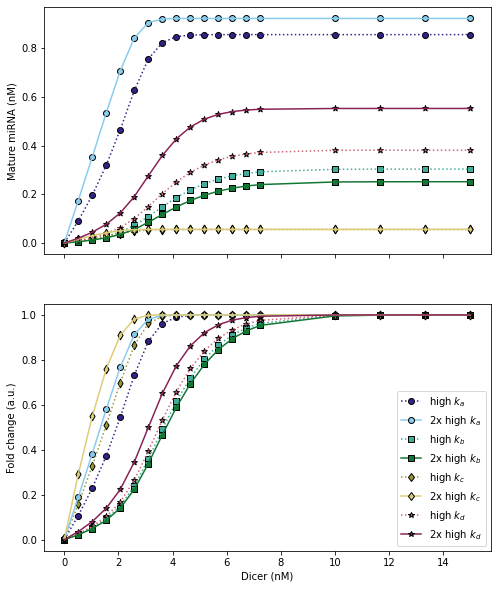

In [17]:
fig, ax = plt.subplots(2, sharex = True, figsize = (8, 10))

ax[0].set_ylabel('Mature miRNA (nM)')
ax[1].set_ylabel('Fold change (a.u.)')
ax[1].set_xlabel('Dicer (nM)')

for i in range(8):
    if i < 4:
        ax[0].plot(dvars,
                   ends[str(i)],
                   color = params.colors[i][0],
                   linestyle = ':')
        ax[1].plot(dvars,
                   fc[str(i)],
                   color = params.colors[i][0],
                   linestyle = ':')
        
        ax[0].scatter(dvars,
                      ends[str(i)],
                      color = params.colors[i][0],
                      marker = markers[i],
                     linewidths = 1,
                     edgecolor = 'black')
        ax[1].scatter(dvars,
                      fc[str(i)],
                      color = params.colors[i][0],
                      marker = markers[i],
                     linewidths = 1,
                     edgecolor = 'black')
        
    else:
        ax[0].plot(dvars,
                   ends[str(i)],
                   color = params.colors[i-4][1],
                   linestyle = '-')
        ax[1].plot(dvars,
                   fc[str(i)],
                   color = params.colors[i-4][1],
                   linestyle = '-')
        
        ax[0].scatter(dvars,
                      ends[str(i)],
                      color = params.colors[i-4][1],
                      marker = markers[i-4],
                     linewidths = 1,
                     edgecolor = 'black')
        ax[1].scatter(dvars,
                      fc[str(i)],
                      color = params.colors[i-4][1],
                      marker = markers[i-4],
                     linewidths = 1,
                     edgecolor = 'black')
        
leg1 = []
leg2 = []
for i in range(len(mirnas)):
    if i < 4:
        leg1.append(mlines.Line2D([], [], linestyle = ':', marker = markers[i], \
                                 color = params.colors[i][0], markeredgecolor = 'black', label = mirnas[i]))
    else:
        leg2.append(mlines.Line2D([], [], linestyle = '-', marker = markers[i-4], \
                                 color = params.colors[i-4][1], markeredgecolor = 'black', label = mirnas[i]))
leg = []
for i in range(len(leg1)):
    leg.append(leg1[i])
    leg.append(leg2[i])
plt.legend(handles = leg)

plt.savefig(destdir_figs + 'mat_mirna-fc.svg', dpi = 600, bbox_inches = 'tight')
        
plt.show()

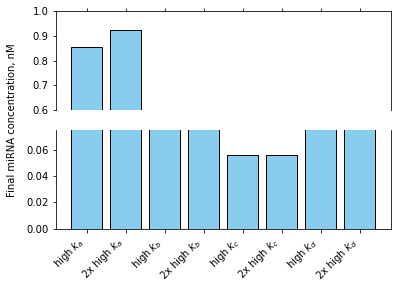

In [18]:
# plot bar chart of final miRNA %
x = np.linspace(1, 8, 8)
fig, (ax1, ax2) = plt.subplots(2,1, sharex = True)
plt.xticks(rotation=45, ha='right')

ax = fig.add_subplot(111)
ax.set_ylabel('Final miRNA concentration, nM\n')
for spine in ax.spines:
    ax.spines[spine].set_color('none')
ax.tick_params(labelcolor='None', top=False, bottom=False, left=False, right=False)
ax.set(facecolor='None')

labels = []
    
for i in range(4):
    ax1.bar([x[int(i*2)], x[int(i*2)+1]],
            height = [ends[str(i)][-1], ends[str(i+4)][-1]],
            color = params.colors[0][1],
            edgecolor = 'black')
    ax2.bar([x[int(i*2)], x[int(i*2)+1]],
            height = [ends[str(i)][-1], ends[str(i+4)][-1]],
            color = params.colors[0][1],
            edgecolor = 'black')
    labels.append(mirnas[i])
    labels.append(mirnas[i+4])
    
ax1.set_xticks(x, labels)    
ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

ax2.set_ylim(0,0.075)
ax1.set_ylim(0.6,1.)

plt.savefig(destdir_figs + 'max_expression.svg', dpi = 600, bbox_inches = 'tight')

plt.show()

In [19]:
ends['7'][-1]

0.5527320294104762

In [20]:
#find Dicer concentration required to reach .50 FC
_50 = {}
for key in fc:
    _50[key] = np.interp(.5, fc[key], dvars)

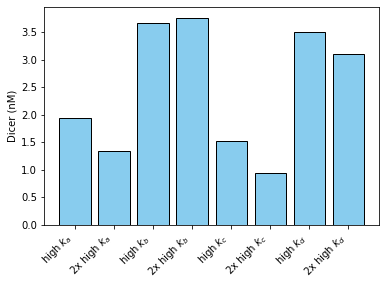

In [21]:
#plot bar chart with Dicer concentration 
fig, ax = plt.subplots()

plt.xticks(rotation = 45, ha = 'right')
labels = []
for i in range(4):
    ax.bar([x[int(i*2)], x[int(i*2)+1]],
           height = [_50[str(i)], _50[str(i+4)]],
           color = params.colors[0][1],
            edgecolor = 'black')
    
    labels.append(mirnas[i])
    labels.append(mirnas[i+4])

ax.set_xticks(x, labels)
ax.set_ylabel('Dicer (nM)')
    
plt.savefig(destdir_figs + '50FC_Dicer.svg', dpi = 600, bbox_inches = 'tight')

plt.show()

In [22]:
np.max(np.array(model_51['pMiR0']))

1.0

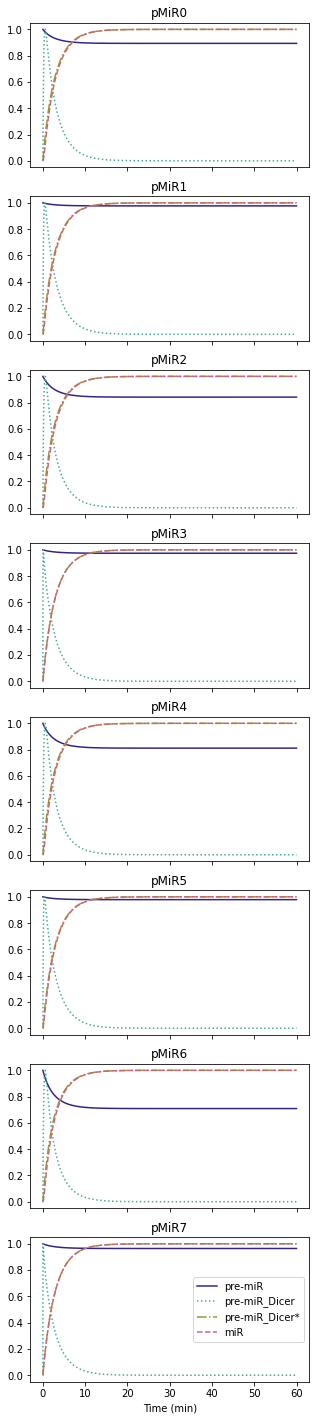

In [23]:
#plot all species on same plot for .5nM Dicer
fig, ax = plt.subplots(8, sharex = True, sharey = True, figsize = (5, 25))

for i in range(8):
    ax[i].plot(model_51['time_min'],
               model_51['pMiR' + str(i)] / np.max(np.array(model_51['pMiR' + str(i)])),
               color = params.colors[0][0],
               linestyle = ['-', ':', '-.', '--'][0])
    ax[i].plot(model_51['time_min'],
               model_51['pMiR_dicer' + str(i)] / np.max(np.array(model_51['pMiR_dicer' + str(i)])),
               color = params.colors[1][0],
               linestyle = ['-', ':', '-.', '--'][1])
    ax[i].plot(model_51['time_min'],
               model_51['pMiR_dicer_star' + str(i)] / np.max(np.array(model_51['pMiR_dicer_star' + str(i)])),
               color = params.colors[2][0],
               linestyle = ['-', ':', '-.', '--'][2])
    ax[i].plot(model_51['time_min'],
               model_51['miR' + str(i)] / np.max(np.array(model_51['miR' + str(i)])),
               color = params.colors[3][0],
               linestyle = ['-', ':', '-.', '--'][3])
    ax[i].set_title('pMiR' + str(i))
    
    leg = []
    for j in range(4):
        leg.append(mlines.Line2D([], [], linestyle = ['-', ':', '-.', '--'][j],
                                 color = params.colors[j][0],
                                 label = ['pre-miR', 'pre-miR_Dicer', 'pre-miR_Dicer*', 'miR'][j]))
        
    plt.legend(handles = leg)
    
ax[-1].set_xlabel('Time (min)')

plt.savefig(destdir_figs + 'time_05nM-Dicer.svg', dpi = 600, bbox_inches = 'tight')

plt.show()

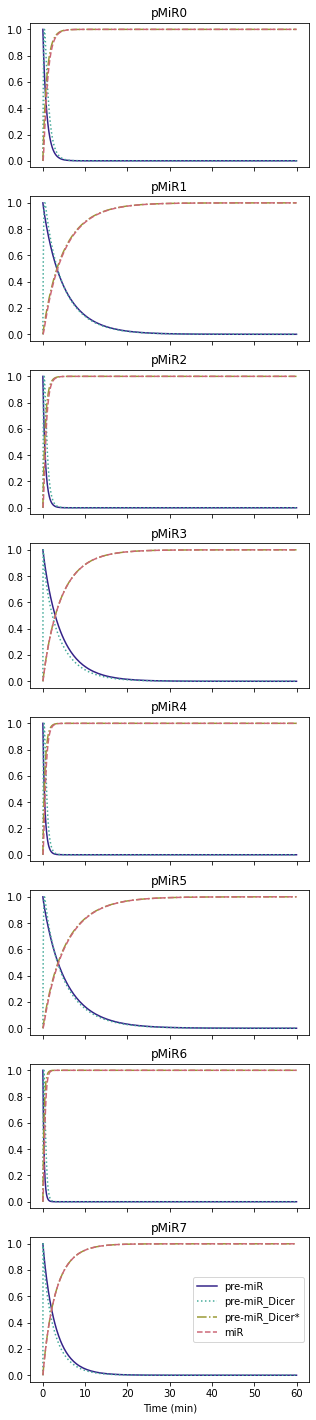

In [25]:
#plot all species on same plot for .5nM Dicer
fig, ax = plt.subplots(8, sharex = True, sharey = True, figsize = (5, 25))

for i in range(8):
    ax[i].plot(model_1500['time_min'],
               model_1500['pMiR' + str(i)] / np.max(np.array(model_1500['pMiR' + str(i)])),
               color = params.colors[0][0],
               linestyle = ['-', ':', '-.', '--'][0])
    ax[i].plot(model_1500['time_min'],
               model_1500['pMiR_dicer' + str(i)] / np.max(np.array(model_1500['pMiR_dicer' + str(i)])),
               color = params.colors[1][0],
               linestyle = ['-', ':', '-.', '--'][1])
    ax[i].plot(model_1500['time_min'],
               model_1500['pMiR_dicer_star' + str(i)] / np.max(np.array(model_1500['pMiR_dicer_star' + str(i)])),
               color = params.colors[2][0],
               linestyle = ['-', ':', '-.', '--'][2])
    ax[i].plot(model_1500['time_min'],
               model_1500['miR' + str(i)] / np.max(np.array(model_1500['miR' + str(i)])),
               color = params.colors[3][0],
               linestyle = ['-', ':', '-.', '--'][3])
    ax[i].set_title('pMiR' + str(i))
    
    leg = []
    for j in range(4):
        leg.append(mlines.Line2D([], [], linestyle = ['-', ':', '-.', '--'][j],
                                 color = params.colors[j][0],
                                 label = ['pre-miR', 'pre-miR_Dicer', 'pre-miR_Dicer*', 'miR'][j]))
        
    plt.legend(handles = leg)
    
ax[-1].set_xlabel('Time (min)')

plt.savefig(destdir_figs + 'time_15nM-Dicer.svg', dpi = 600, bbox_inches = 'tight')

plt.show()